In [1]:
import numpy as np
empirical = np.load('data/SC_wei_HCP_s400.npy')
empirical_coords = np.load('data/s400_coords.npy')

In [2]:
import os
import pickle

experiment_path = 'results/empirical/empirical_MC_gamma1/'
module_mappings = pickle.load(open(os.path.join(experiment_path, 'network_data/module_mappings.pickle'), 'rb'))
module_mappings_level2 = pickle.load(open(os.path.join(experiment_path, 'network_data/module_mappings_level2.pickle'), 'rb'))

In [3]:
from bct.utils import get_rng
from randmio_und_hmod import category_rewiring

#adapted from https://github.com/aestrivex/bctpy/blob/master/bct/algorithms/reference.py#L1479
#Hierarchical modularity and degree-preserving rewiring (returns category_bool)
def randmio_und_hmod(R, partitions, itr=10, seed=None):

    R = R.copy()
    if not np.allclose(R, R.T):
        raise ValueError("Input must be undirected")
    n = len(R)
    nlevels = partitions.shape[0]
    
    #Edge categories
    category_bool = np.zeros((nlevels + 1, n, n), dtype=bool)
    for level in range(nlevels):
        partition = partitions[level]
        for module in np.unique(partition):
            nodes = np.where(partition == module)[0]
            within_module_idx = np.ix_(nodes, nodes)
            category_bool[level][within_module_idx] = True
    
    category_bool[-1] = True

    #In reverse order of level, take out the indices of the previous level
    for level in range(nlevels, 0, -1):
        category_bool[level] = category_bool[level] & ~category_bool[level - 1]

    #Rewiring within each category
    B = np.zeros((n, n))
    eff_hierarchy = []
    for level in range(nlevels + 1):
        R_category = R.copy()
        R_category[~category_bool[level]] = 0
        B_category, eff = category_rewiring(R_category, category_bool[level], 
                                            itr, seed)
        B += B_category
        eff_hierarchy.append(eff)

    return B, eff_hierarchy, category_bool

In [4]:
mod_null, eff, mod_category_bool = randmio_und_hmod(empirical, np.array([module_mappings]), itr=25, seed=0)
hmod_null, eff, hmod_category_bool = randmio_und_hmod(empirical, np.array([module_mappings, module_mappings_level2]), itr=25, seed=0)

In [5]:
#create the index that sorts level 1 modules within level 2 modules
inds = []
for mod in np.unique(module_mappings_level2):
    mod_idx = np.where(module_mappings_level2 == mod)[0]
    inds.extend(mod_idx[np.argsort(module_mappings[mod_idx])])

In [6]:
partition = module_mappings[inds].copy()
#relabel the modules in partition so that they are in ascending order
label_map = {}
new_partition = []
current_label = 1
for label in partition:
    if label not in label_map:
        label_map[label] = current_label
        current_label += 1
    new_partition.append(label_map[label])
new_partition = np.array(new_partition)

In [7]:
from netneurotools.plotting import plot_mod_heatmap
from score_plotting_utils import create_fig_path

fig_path = create_fig_path(experiment_path)

def save_mod_heatmap(ax, filename):
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_yticklabels([])

    for coll in ax.collections:
        coll.set_rasterized(True)
    
    ax.figure.savefig(os.path.join(fig_path, filename), dpi=300, bbox_inches='tight')

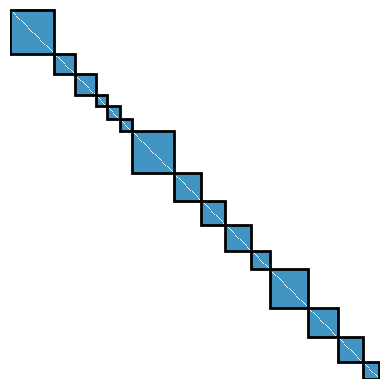

In [8]:
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap

PuBu = cm.get_cmap('PuBu')
blue_cmap = LinearSegmentedColormap.from_list("PuBuW", ['white', PuBu(0.6)])

ax = plot_mod_heatmap(mod_category_bool[0][np.ix_(inds, inds)], new_partition, 
                      inds=list(range(len(inds))), cmap=blue_cmap, cbar=False)
save_mod_heatmap(ax, 'category1_level1.png')
save_mod_heatmap(ax, 'category1_level1.svg')

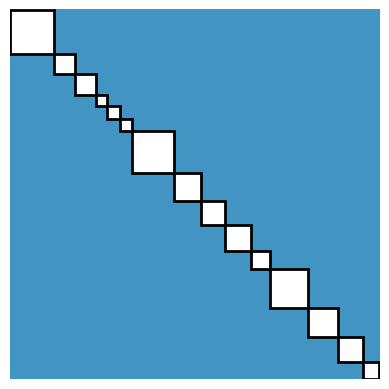

In [9]:
ax = plot_mod_heatmap(mod_category_bool[1][np.ix_(inds, inds)], new_partition, 
                      inds=list(range(len(inds))), cmap=blue_cmap, cbar=False)
save_mod_heatmap(ax, 'category2_level1.png')
save_mod_heatmap(ax, 'category2_level1.svg')

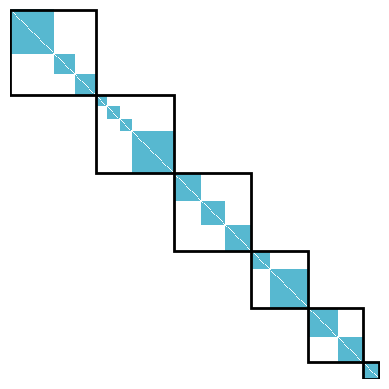

In [10]:
GnBu = cm.get_cmap('GnBu')
green_cmap = LinearSegmentedColormap.from_list("GnBuW", ['white', GnBu(0.6)])

ax = plot_mod_heatmap(hmod_category_bool[0][np.ix_(inds, inds)], module_mappings_level2[inds], 
                      inds=list(range(len(inds))), cmap=green_cmap, cbar=False)
save_mod_heatmap(ax, 'category1_level2.png')
save_mod_heatmap(ax, 'category1_level2.svg')

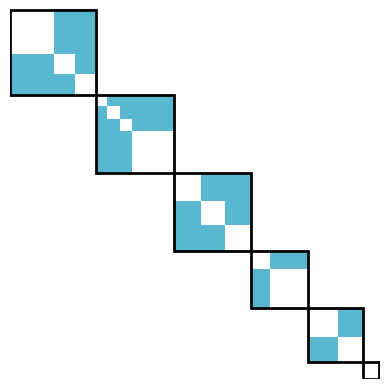

In [11]:
ax = plot_mod_heatmap(hmod_category_bool[1][np.ix_(inds, inds)], module_mappings_level2[inds], 
                      inds=list(range(len(inds))), cmap=green_cmap, cbar=False)
save_mod_heatmap(ax, 'category2_level2.png')
save_mod_heatmap(ax, 'category2_level2.svg')

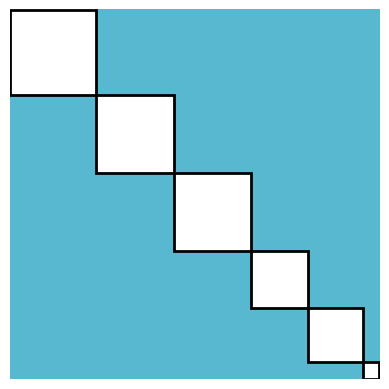

In [12]:
ax = plot_mod_heatmap(hmod_category_bool[2][np.ix_(inds, inds)], module_mappings_level2[inds], 
                      inds=list(range(len(inds))), cmap=green_cmap, cbar=False)
save_mod_heatmap(ax, 'category3_level2.png')
save_mod_heatmap(ax, 'category3_level2.svg')

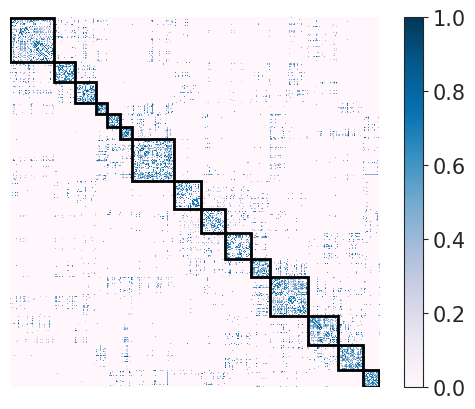

In [13]:
empirical = empirical[np.ix_(inds, inds)].copy()
ax = plot_mod_heatmap(empirical, new_partition, inds=list(range(len(inds))), cmap='PuBu')
save_mod_heatmap(ax, 'empirical_level1.png')
save_mod_heatmap(ax, 'empirical_level1.svg')

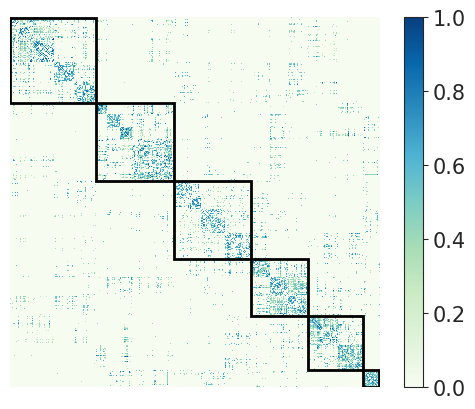

In [14]:
ax = plot_mod_heatmap(empirical, module_mappings_level2[inds], inds=list(range(len(inds))), cmap='GnBu')
save_mod_heatmap(ax, 'empirical_level2.png')
save_mod_heatmap(ax, 'empirical_level2.svg')

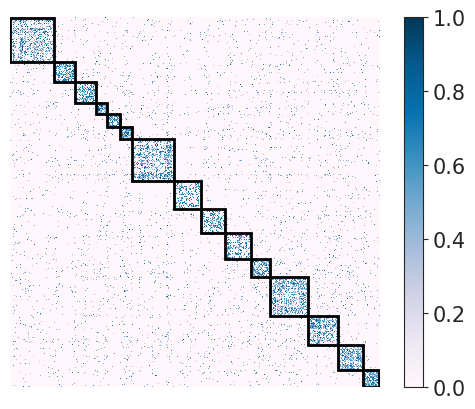

In [15]:
mod_null = mod_null[np.ix_(inds, inds)].copy()
ax = plot_mod_heatmap(mod_null, new_partition, inds=list(range(len(inds))), cmap='PuBu')
save_mod_heatmap(ax, 'mod_null_level1.png')
save_mod_heatmap(ax, 'mod_null_level1.svg')

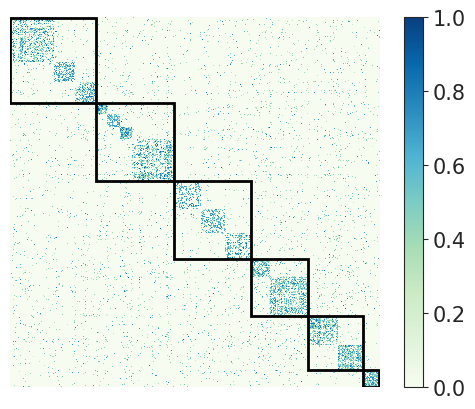

In [16]:
ax = plot_mod_heatmap(mod_null, module_mappings_level2[inds], inds=list(range(len(inds))), cmap='GnBu')
save_mod_heatmap(ax, 'mod_null_level2.png')
save_mod_heatmap(ax, 'mod_null_level2.svg')

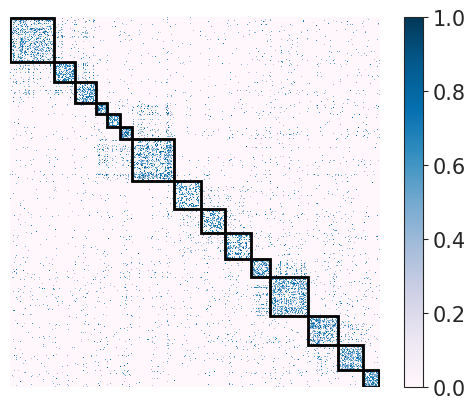

In [17]:
hmod_null = hmod_null[np.ix_(inds, inds)].copy()
ax = plot_mod_heatmap(hmod_null, new_partition, inds=list(range(len(inds))), cmap='PuBu')
save_mod_heatmap(ax, 'hmod_null_level1.png')
save_mod_heatmap(ax, 'hmod_null_level1.svg')

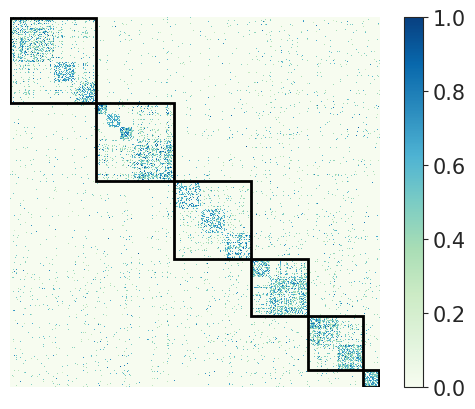

In [18]:
ax = plot_mod_heatmap(hmod_null, module_mappings_level2[inds], inds=list(range(len(inds))), cmap='GnBu')
save_mod_heatmap(ax, 'hmod_null_level2.png')
save_mod_heatmap(ax, 'hmod_null_level2.svg')

In [19]:
from plot_point_brain import plot_point_brain
from matplotlib.colors import ListedColormap
colors = ["#ff6f69", "#ff8c94", "#ffb347", "#c1e1c1", "#77dd77", 
          "#779ecb", "#c38ec7", "#8aaae5", "#69c9d0", "#03c03c", 
          "#fdfd96", "#f49ac2", "#b19cd9", "#ffa07a", "#9d94ff"]
cmap = ListedColormap(colors)

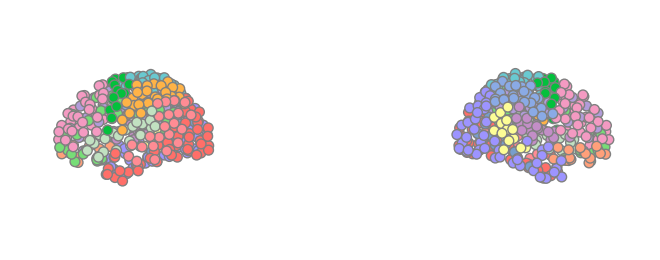

In [20]:
fig, ax = plot_point_brain(module_mappings, empirical_coords, views=['sag1', 'sag2'], views_orientation='horizontal', cmap=cmap, alpha=1)
fig.savefig(os.path.join(fig_path, 'point_brain_level1.png'), dpi=300, bbox_inches='tight')

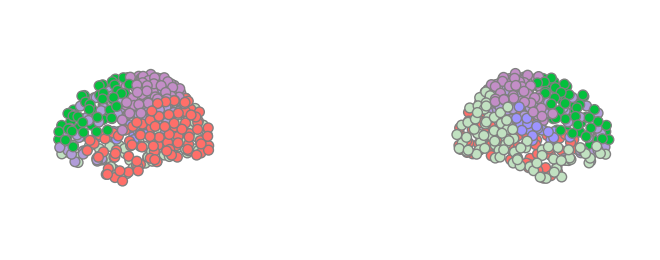

In [21]:
fig, ax = plot_point_brain(module_mappings_level2, empirical_coords, views = ['sag1', 'sag2'], views_orientation ='horizontal', cmap=cmap, alpha=1)
fig.savefig(os.path.join(fig_path, 'point_brain_level2.png'), dpi=300, bbox_inches='tight')